In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
import env
import os
import os
import acquire as a
import prepare as p
# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
# read in csv
df = pd.read_csv('saas.csv')

In [3]:
# check it out
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
# check for null values
df.isnull().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [5]:
# check out details of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [6]:
# make all columns lower case
df.columns = df.columns.str.lower()
df.head()

,month_invoiced,customer_id,invoice_id,subscription_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [7]:
df.dtypes

month_invoiced        object
customer_id            int64
invoice_id             int64
subscription_type    float64
amount               float64
dtype: object

In [8]:
# set column to_datetime
df.month_invoiced = pd.to_datetime(df['month_invoiced'])



In [9]:
df.dtypes

month_invoiced       datetime64[ns]
customer_id                   int64
invoice_id                    int64
subscription_type           float64
amount                      float64
dtype: object

In [10]:
#make that value our index
df = df.set_index('month_invoiced').sort_index()

# 1
Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [11]:
# resample by day, sum
df_resampled = df.resample('m')[['amount']].sum()
df_resampled.head(2)

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0


In [12]:
# Drop February 29th from our dataset (a leap year date)
df_ressampled = df_resampled[df_resampled.index != '2016-02-29']

In [13]:
df_ressampled.head()

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [14]:
df_resampled.shape

(48, 1)

In [15]:
# take 50% of our data for train (round to integer for a whole number)
train_size = int(.5 * len(df_resampled))
# take 30% for validation
validate_size = int(len(df_resampled) * .3)
# get the remainder or rows for test
test_size = int(len(df_resampled) - train_size - validate_size)
# get the delineation point between validate and test by summing train and validate
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [16]:
train.shape[0] +validate.shape[0]+ test.shape[0]

48

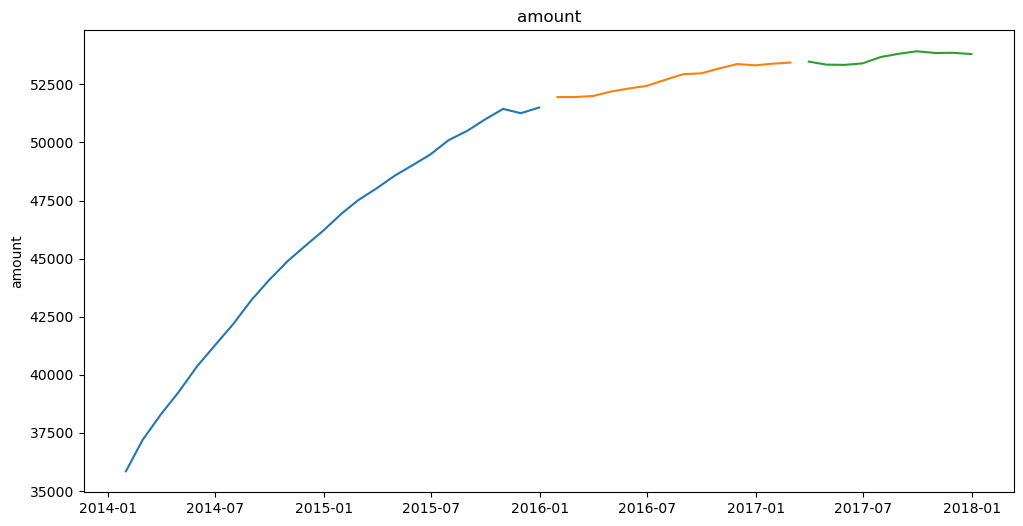

In [17]:
# plotting the values of amount over time by data subset:
for col in train.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# helper functions

In [18]:
# evaluation function to compute rmse
# calculate an error metric on the validation's target versus predictions
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ),0)
    return rmse

In [19]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse)}')
    plt.show()

In [20]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [21]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

# Last Observed Value

In [22]:
# going forward form the -1st element in the train's amount
# then rip out the value associated
train['amount'][-1:][0]

51505.0

In [23]:
# take the last item of amount and assign to variable
# indexing: last thing to the end, then the first element
last_amount = train['amount'][-1:][0]



# let's make the prediction dataframe that we referenced a little earlier
yhat_df = pd.DataFrame(
    {
    'amount': [last_amount],
    }, 
    index = validate.index
)

In [24]:
# use the plot and eval function we defined earlier for both targets:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


amount -- rmse: 1343


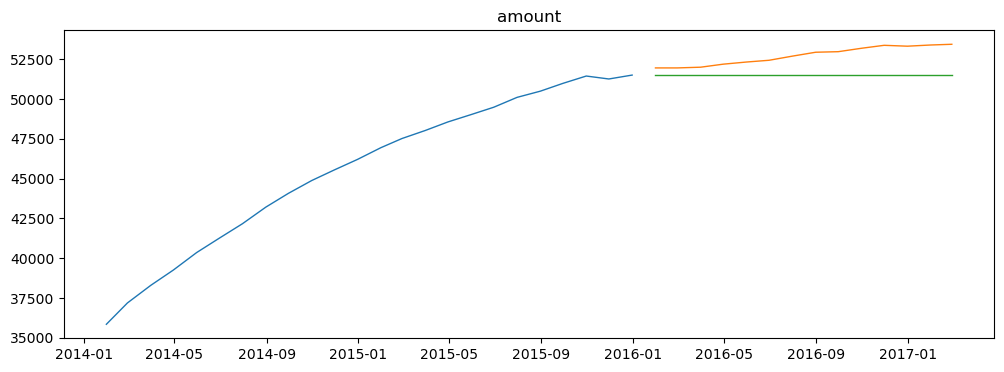

In [25]:
for col in train.columns:
    plot_and_eval(col)

In [26]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                            target_var=col)

In [27]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


# Simple Average

In [28]:
# compute simple average of sales_total (from train data)
avg_amount = round(train['amount'].mean(),2)

yhat_df = pd.DataFrame({'amount': [avg_amount],
                        },
                        index=validate.index)

yhat_df.head(3)

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54


amount -- rmse: 7181


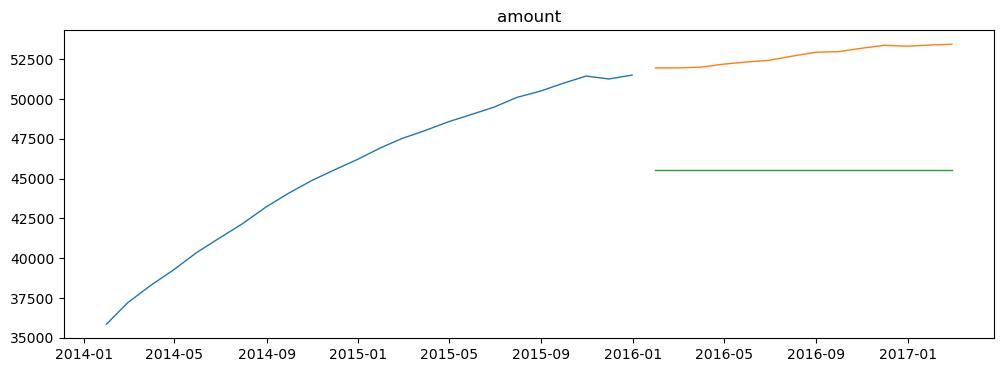

In [29]:
# plot actuals vs. predicted
for col in train.columns:
    plot_and_eval(col)

In [30]:
# evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
0,simple_average,amount,7181.0


# Moving Average

In [57]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 12

rolling_amount = round(train['amount'].rolling(period).mean()[-1],2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': rolling_amount,
                        },
                         index=validate.index)
yhat_df.head()

,amount
month_invoiced,
2016-01-31,49612.92
2016-02-29,49612.92
2016-03-31,49612.92
2016-04-30,49612.92
2016-05-31,49612.92


amount -- rmse: 3164


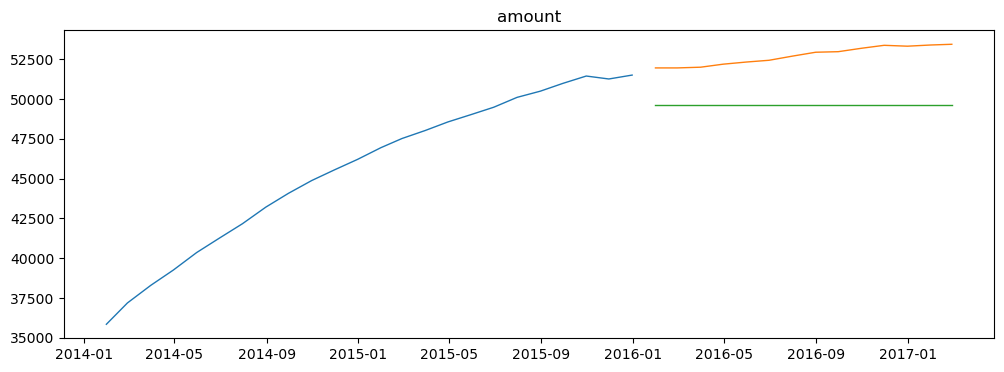

In [58]:
# plot actual vs. predicted
for col in train.columns:
    plot_and_eval(col)

In [59]:
# evaluate on 1 year moving average
for col in train.columns:
    eval_df = append_eval_df(model_type='1Y moving avg', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
0,simple_average,amount,7181.0
0,1Y moving avg,amount,7181.0
0,2_month_moving_avg,amount,3164.0
0,3_month_moving_avg,amount,3164.0
0,6_month_moving_avg,amount,3164.0
0,holts_optimized,amount,456.0
0,holts_seasonal,amount,1502.0
0,1Y moving avg,amount,3164.0


In [60]:
# try bi-monthly, quarterly, half-year
periods = [2, 3, 6,]

for p in periods: 
    rolling_amount = round(train['amount'].rolling(period).mean()[-1],2)
    
    yhat_df = pd.DataFrame(
        {
            'amount' : [rolling_amount],
        },
        index = validate.index
    )
    model_type = str(p) + '_month_moving_avg'
    # lets update the eval_df (remember we have two targets!)
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, target_var = col)

In [34]:
#check it out
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
0,simple_average,amount,7181.0
0,1Y moving avg,amount,7181.0
0,2_month_moving_avg,amount,3164.0
0,3_month_moving_avg,amount,3164.0
0,6_month_moving_avg,amount,3164.0


In [35]:
#what is the best so far?
# get the min rmse for each variable

min_rmse_amount_total = eval_df.groupby('target_var')['rmse'].min()


# filter only the rows that match those rmse to find out 
# which models are best thus far
min_rmse_amount_total

target_var
amount    1343.0
Name: rmse, dtype: float64

# Holt's Linear Trend

In [36]:
# make the thing to iterate through the columns
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start=validate.index[0],
                                end=validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

In [37]:
#check out the yhat df
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51748.62
2016-02-29,51961.99
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04


amount -- rmse: 456


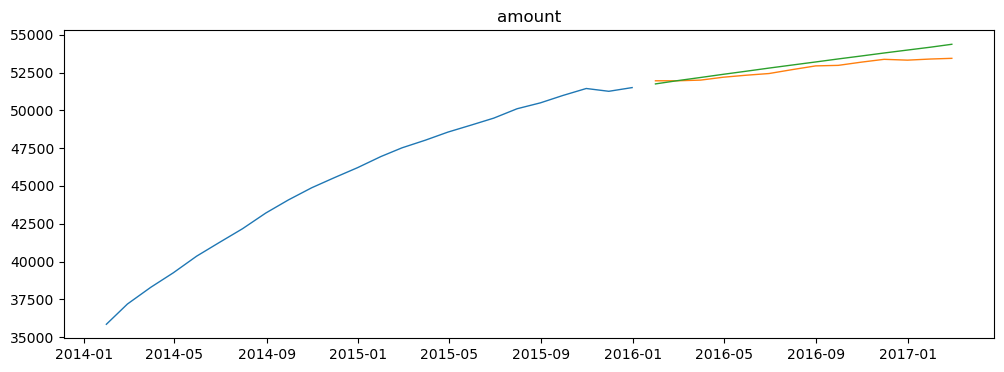

In [38]:
# plot actuals vs. predicted values
for col in train.columns:
    plot_and_eval(target_var = col)

In [39]:
# evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [40]:
# check it out
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
0,simple_average,amount,7181.0
0,1Y moving avg,amount,7181.0
0,2_month_moving_avg,amount,3164.0
0,3_month_moving_avg,amount,3164.0
0,6_month_moving_avg,amount,3164.0
0,holts_optimized,amount,456.0


# Holts Seasonal

In [41]:
import itertools

In [42]:
combos = list(itertools.product(['add','mul'],[True, False]))

In [43]:
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [44]:
hsts = {}
for col in train.columns:
    hsts[col] = {}
    for i, combo in enumerate (combos):
        hsts[col]['hst_fit_' + str(i)]= \
        ExponentialSmoothing(train[col],
                             seasonal_periods=12,
                             trend='add',
                            seasonal = combo[0],
                            damped=combo[1]).fit()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [45]:

hsts.keys()

dict_keys(['amount'])

In [46]:
hsts['amount']

{'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x7fdf00887610>,
 'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x7fdf00d4a100>,
 'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x7fdf00872460>,
 'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x7fdf00883490>}

In [47]:
best_score= 'placeholder'
for model in hsts['amount']:
    score = (hsts['amount'][model].sse / len(train)) ** .5
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

In [48]:
hsts['amount']['hst_fit_1'].forecast(validate.shape[0] + 1)

2016-01-31    50664.516323
2016-02-29    52217.240318
2016-03-31    52551.894342
2016-04-30    52800.573350
2016-05-31    53159.215326
2016-06-30    53441.182443
2016-07-31    53897.175360
2016-08-31    54306.491552
2016-09-30    54712.380271
2016-10-31    55152.621113
2016-11-30    55220.139687
2016-12-31    55487.760885
2017-01-31    54644.160034
2017-02-28    56196.884029
2017-03-31    56531.538053
Freq: M, dtype: float64

In [49]:
yhat_df = pd.DataFrame({'amount': hsts['amount']['hst_fit_1'].forecast(validate.shape[0] + 1),
                           },
                          index=validate.index)
yhat_df

,amount
month_invoiced,
2016-01-31,50664.516323
2016-02-29,52217.240318
2016-03-31,52551.894342
2016-04-30,52800.573350
2016-05-31,53159.215326
2016-06-30,53441.182443
2016-07-31,53897.175360
2016-08-31,54306.491552
2016-09-30,54712.380271


amount -- rmse: 1502


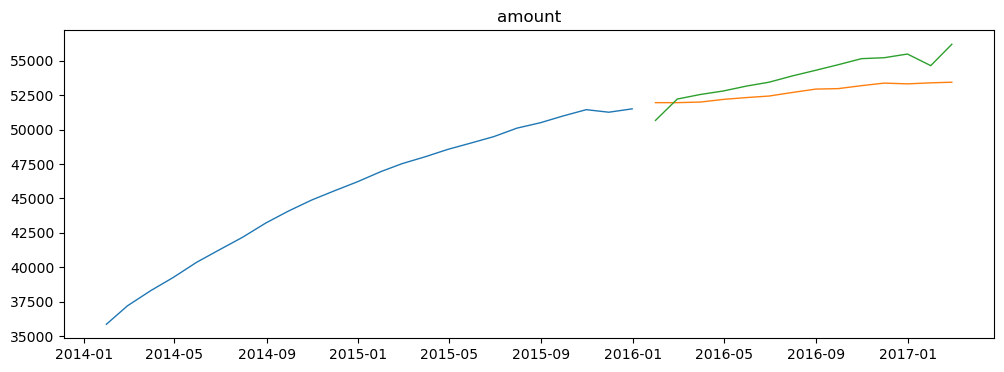

In [50]:
for col in train.columns:
    plot_and_eval(col)

In [51]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [52]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,holts_optimized,amount,456.0
0,last_observed_value,amount,1343.0
0,holts_seasonal,amount,1502.0
0,2_month_moving_avg,amount,3164.0
0,3_month_moving_avg,amount,3164.0
0,6_month_moving_avg,amount,3164.0
0,simple_average,amount,7181.0
0,1Y moving avg,amount,7181.0


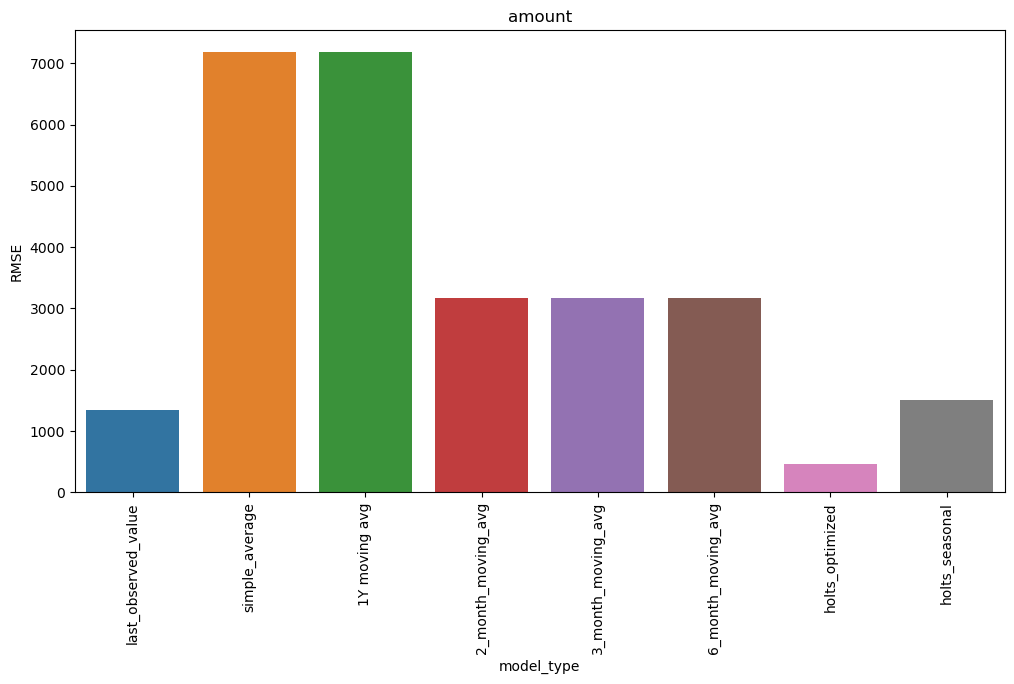

In [53]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x, y=y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.show()

# Evaluate on test

In [54]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]
train.shape, validate.shape, test.shape

((24, 1), (14, 1), (10, 1))

In [64]:
yhat_values = model.predict(start=test.index[0],
                                end=test.index[-1])



In [81]:
test.index[-1] + 12

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [68]:
yhat_df = pd.DataFrame(index=test.index, columns=test.columns)

In [65]:
yhat_values

2017-03-31    54558.269215
2017-04-30    54744.955176
2017-05-31    54929.867623
2017-06-30    55113.023404
2017-07-31    55294.439209
2017-08-31    55474.131566
2017-09-30    55652.116848
2017-10-31    55828.411273
2017-11-30    56003.030903
2017-12-31    56175.991650
Freq: M, dtype: float64

In [69]:
yhat_df.amount = yhat_values
yhat_df

,amount
month_invoiced,
2017-03-31,54558.269215
2017-04-30,54744.955176
2017-05-31,54929.867623
2017-06-30,55113.023404
2017-07-31,55294.439209
2017-08-31,55474.131566
2017-09-30,55652.116848
2017-10-31,55828.411273
2017-11-30,56003.030903


In [75]:
forecast = pd.DataFrame({'amount': yhat_df['amount'].forecast(test.shape[0] + 1 + 12)
                        })

forecast

AttributeError: 'Series' object has no attribute 'forecast'

In [70]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

NameError: name 'forecast' is not defined

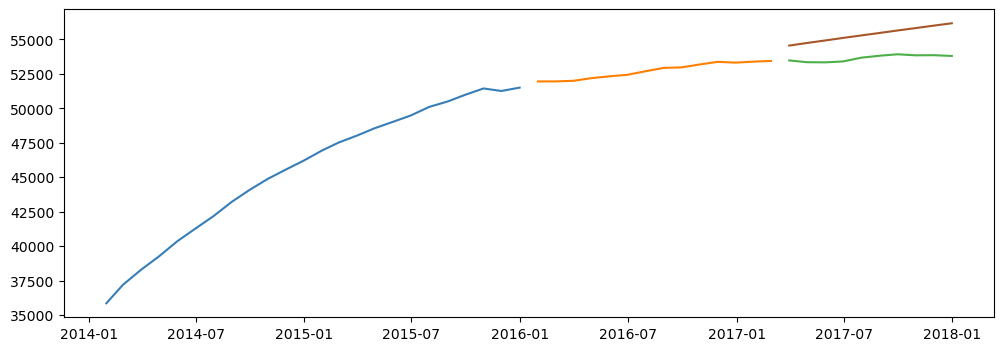

In [71]:
for col in train.columns:
    final_plot(col)